In [33]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt

from shapely import wkt
from shapely.geometry import Point
from tqdm import tqdm

tqdm.pandas()

train = pd.read_csv('data/stores_train.csv')
train = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.lon, train.lat)).drop(columns=['lon', 'lat'])
train = train.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

train_extra = pd.read_csv('data/stores_extra.csv')
train_extra = gpd.GeoDataFrame(train_extra, geometry=gpd.points_from_xy(train_extra.lon, train_extra.lat)).drop(columns=['lon', 'lat'])
train_extra = train_extra.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

test = pd.read_csv('data/stores_test.csv')
test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat)).drop(columns=['lon', 'lat'])
test = test.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

In [13]:
train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,chain_name,mall_name,revenue,geometry
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,MCDONALDS,Magasinet Drammen,17.998,POINT (1136007.376 8342763.593)
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,MCDONALDS,NaN,23.828,POINT (1194906.839 8380562.352)
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,BURGER KING,Kuben Hønefoss,16.099,POINT (1141543.072 8436509.485)
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,BURGER KING,Glasshuspassasjen,9.296,POINT (1600751.595 10237351.427)
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,BURGER KING,Tillertorget,4.528,POINT (1154921.068 9188593.406)


In [23]:
data = pd.concat([train, train_extra], ignore_index=True)[['store_id', 'geometry']]

def store_count_in_vicinity(row: pd.Series):
    stores_in_vicinity = data[data.distance(row.geometry) < 1000]
    return {'stores_count_lt_1km': len(stores_in_vicinity)}


data = data.join(data.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
data.to_parquet('derived_data/stores_count_lt_1km_train')


100%|██████████| 41543/41543 [07:00<00:00, 98.72it/s] 


<AxesSubplot: >

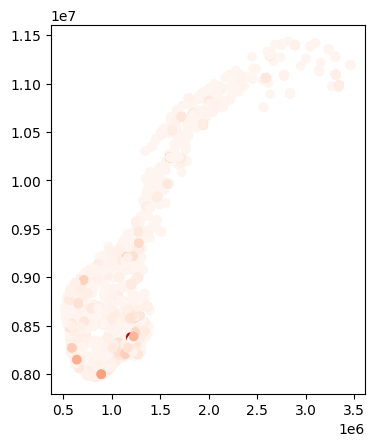

In [52]:
stores = gpd.read_parquet('derived_data/stores_count_lt_1km_train')
# print(len(stores_count_lt_1km), len(data))
# plt.hist(np.log1p(stores_count_lt_1km.stores_count_lt_1km), bins=15)


train_w_counts = pd.merge(train, stores.drop(columns=['geometry']), on='store_id', how='left')
train_w_counts = gpd.GeoDataFrame(train_w_counts, geometry=train_w_counts.geometry)
# train_w_counts = train_w_counts.set_crs('epsg:3857')

train_w_counts.plot(column='stores_count_lt_1km', cmap='Reds')

# stores[stores.stores_count_lt_1km > 100].plot(column='stores_count_lt_1km', cmap='Reds')

# stores